# Running Neural GAM - Linear regression

1. Install requirements
2. Load data
3. Train NeuralGAM
4. Visualize partial dependence plots

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import pandas as pd

Load dataset into Pandas Dataframes. If you want to preprocess or select some features, do it here. Our synthetic dataset is composed of train and test files, which we load separately.

In [13]:
from neuralGAM.dataset import generate_data

X_train, y_train, fs_train = generate_data(nrows=24500, err_type="homoscedastic", distribution = "uniform", family = "binomial", seed=343142)
# center theoretical fs for plotting
fs_train = fs_train - fs_train.mean()
y_train_binomial = np.random.binomial(1, y_train, size=y_train.shape[0])


X_test, y_test, fs_test = generate_data(nrows=5000, err_type="homoscedastic", distribution = "uniform", family = "binomial", seed=343142)
# center theoretical fs for plotting
fs_test = fs_test - fs_test.mean()
y_test_binomial = np.random.binomial(1, y_test, size=y_test.shape[0])


Create and Train NeuralGAM instance of Binomial Family. Convert probs in y_train to {1,0} 

In [7]:
y_train

0        0.980726
1        0.488786
2        0.062728
3        0.001250
4        0.008913
           ...   
24495    0.420101
24496    0.071939
24497    0.695262
24498    0.986270
24499    0.948513
Length: 24500, dtype: float64

In [ ]:
from neuralGAM.model import NeuralGAM

output_path = "./results"
# Create results directory
if not os.path.exists(output_path):
    os.makedirs(output_path)

units = [128, 128, 128]
learning_rate = 0.00053

ngam = NeuralGAM(family="binomial", num_units=units, learning_rate=learning_rate)

muhat, fs_train_estimated, eta = ngam.fit(X_train = X_train, 
                                y_train = y_train_binomial, 
                                max_iter_ls = 10, 
                                bf_threshold=10e-5,
                                ls_threshold=0.1,
                                max_iter_backfitting=10,
                                parallel=True)


/home/iortega/miniconda3/envs/test/lib/python3.9/site-packages/neuralGAM/model.py:291: RuntimeWarning: divide by zero encountered in log
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),
/home/iortega/miniconda3/envs/test/lib/python3.9/site-packages/neuralGAM/model.py:291: RuntimeWarning: invalid value encountered in multiply
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),


766/766 [==============================] - 1s 2ms/step


/home/iortega/miniconda3/envs/test/lib/python3.9/site-packages/neuralGAM/model.py:291: RuntimeWarning: divide by zero encountered in log
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),
/home/iortega/miniconda3/envs/test/lib/python3.9/site-packages/neuralGAM/model.py:291: RuntimeWarning: invalid value encountered in multiply
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),


766/766 [==============================] - 1s 2ms/step


/home/iortega/miniconda3/envs/test/lib/python3.9/site-packages/neuralGAM/model.py:291: RuntimeWarning: divide by zero encountered in log
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),
/home/iortega/miniconda3/envs/test/lib/python3.9/site-packages/neuralGAM/model.py:291: RuntimeWarning: invalid value encountered in multiply
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),


766/766 [==============================] - 1s 2ms/step


/home/iortega/miniconda3/envs/test/lib/python3.9/site-packages/neuralGAM/model.py:291: RuntimeWarning: divide by zero encountered in log
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),
/home/iortega/miniconda3/envs/test/lib/python3.9/site-packages/neuralGAM/model.py:291: RuntimeWarning: invalid value encountered in multiply
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),


Once we trained the model, we can visualize the learnt partial effects from the training set. In this case, we will use an auxiliary function that allows us to plot both the original (theretical) functions and the learnt partial effect from the training set

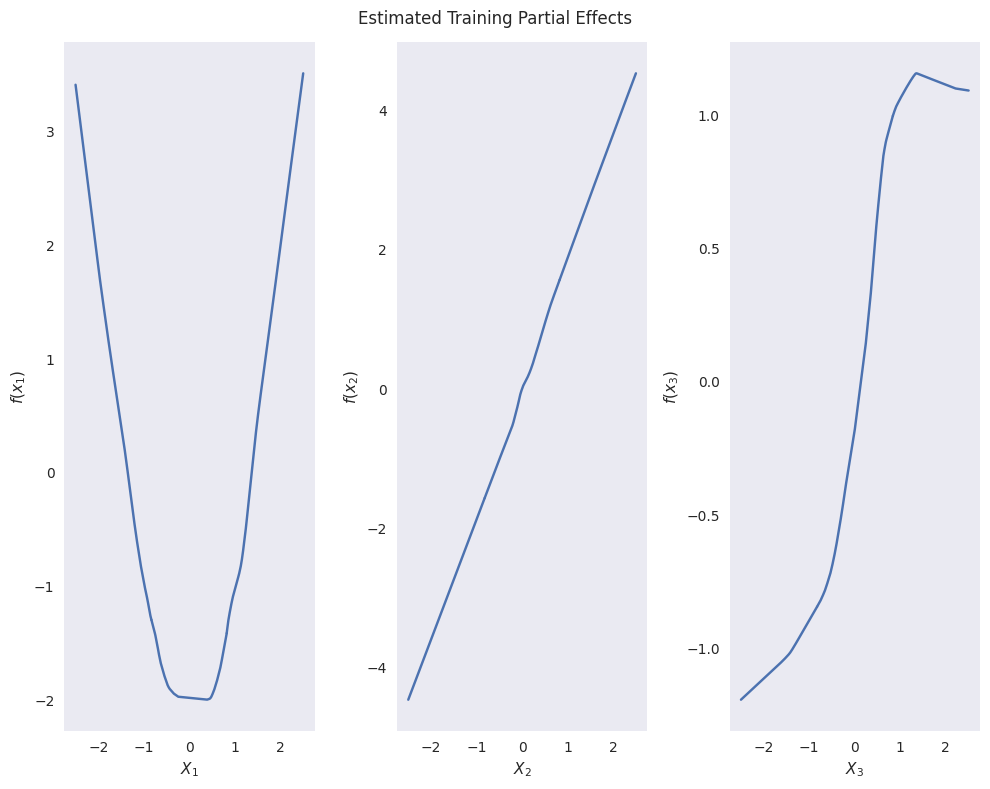

157/157 [==============================] - 0s 848us/step


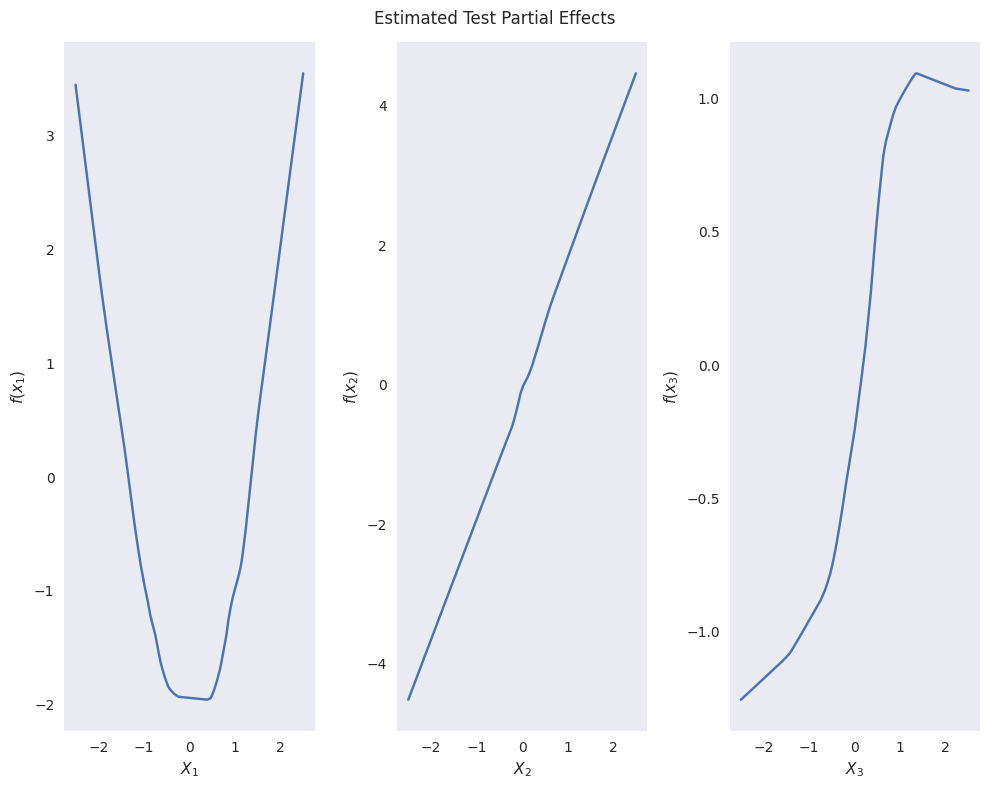

In [9]:
from neuralGAM.plot import plot_partial_dependencies
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plot_partial_dependencies(x=X_train, fs=fs_train_estimated, title="Estimated Training Partial Effects")

fs_test_est = ngam.predict(X_test, type = "terms")
plot_partial_dependencies(x=X_test, fs=fs_test_est, title="Estimated Test Partial Effects")

Since we observe a linear fit for $X_2$ we can force a linear fit for this covariate (using the column name in X_train) using the `linear_terms` parameter and specifying the column name in `X_train` to be fitted using a linear model:

766/766 [==============================] - 1s 1ms/step


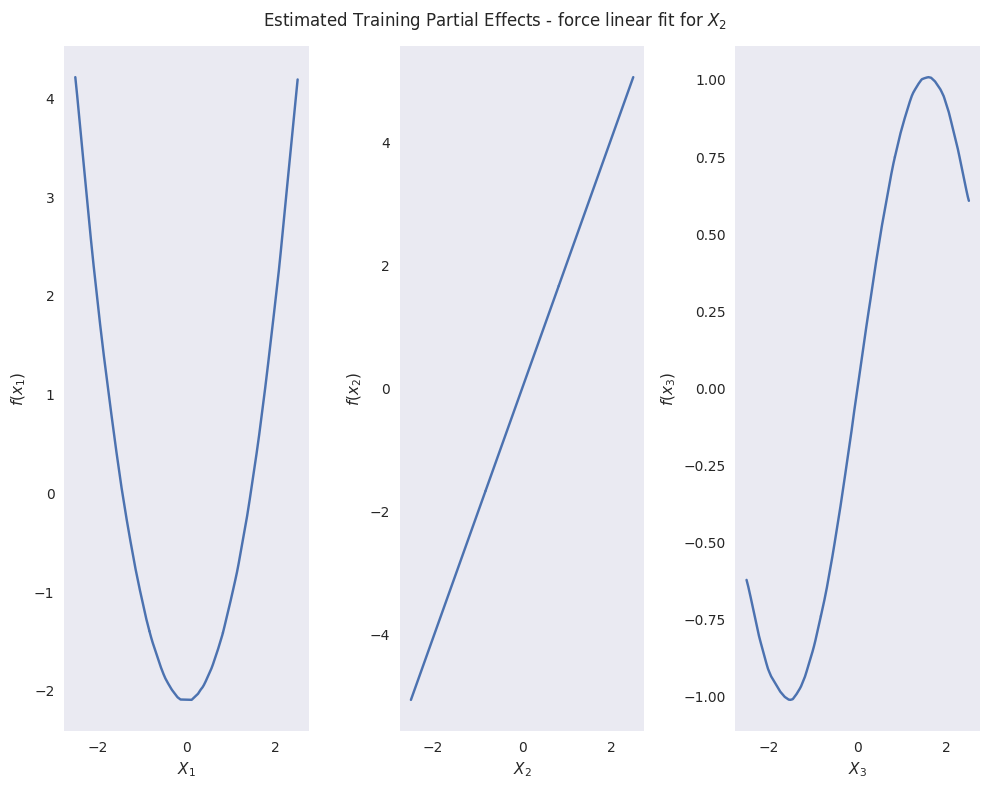

In [10]:
ngam = NeuralGAM(family="binomial", num_units=units, learning_rate=learning_rate, linear_terms=[1])

muhat, fs_train_estimated, eta = ngam.fit(X_train = X_train, 
                                y_train = y_train, 
                                max_iter_ls = 10, 
                                bf_threshold=10e-5,
                                ls_threshold=0.1,
                                max_iter_backfitting=10,
                                parallel=True)

plot_partial_dependencies(x=X_train, fs=fs_train_estimated, title=f"Estimated Training Partial Effects - force linear fit for $X_2$")


We can now use the trained NeuralGAM model to make predictions on unseen data, and compute common binary classification metrics using the Youden index as decission threshold: 

In [21]:
y_pred = ngam.predict(X_test, type = "response")

from neuralGAM.metrics import youden
# compute accuracy and auc-roc using youden index as decission threshold
from sklearn.metrics import accuracy_score, roc_auc_score

youden_index = youden(y_test_binomial, y_pred)

accuracy = accuracy_score(y_test_binomial, y_pred > youden_index)
roc_auc = roc_auc_score(y_test_binomial, y_pred)
print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")

157/157 [==============================] - 0s 775us/step
Accuracy: 0.8728
AUC-ROC: 0.9443554027205967
